In [1]:
 import numpy as np
 import pandas as pd
 from sklearn.model_selection import train_test_split, KFold
 from sklearn.metrics import confusion_matrix, classification_report
 import matplotlib.pyplot as plt
 import seaborn as sns
 from sklearn.preprocessing import StandardScaler

In [2]:
# Charger le dataset
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# Séparer les caractéristiques (X) et la cible (y)
X = data.drop('Outcome', axis=1).values  # Convertir en numpy array
y = data['Outcome'].values.reshape(-1, 1)  # Reshape pour avoir (n, 1)


In [4]:
# Colonnes avec zéros non valides
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# Remplacer les zéros par la médiane
for column in columns_with_zeros:
    data[column] = data[column].replace(0, data[column].median())


In [5]:
# Mettre à jour X après remplacement
X = data.drop('Outcome', axis=1).values
X

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [6]:
# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.63994726,  0.86604475, -0.03198993, ...,  0.16724016,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20506583, -0.5283186 , ..., -0.85155088,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01666174, -0.69376149, ..., -1.33183808,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02157407, -0.03198993, ..., -0.90976751,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14279979, -1.02464727, ..., -0.34215536,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94206766, -0.19743282, ..., -0.29849289,
        -0.47378505, -0.87137393]])

In [7]:
# Division avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


#  2. Implémentation et entraînement

In [9]:
# fonction d'activation 
def relu(X):
 """
 ReLU activation: max(0, x)
 """
 assert isinstance(X, np.ndarray), "Input to ReLU must be anumpy array"
 result=np.maximum(0,X)
 assert np.all(result >= 0), "ReLU output must be non-negative"
 return result
def relu_derivative(X):
    """
    Dérivée de ReLU : 1 si x > 0, sinon 0
    """
    assert isinstance(X, np.ndarray), "L'entrée de la dérivée ReLU doit être un tableau numpy"
    result = np.where(X > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "La dérivée ReLU doit contenir uniquement des 0 ou des 1"
    return result
def sigmoid(X):
    """
    Activation sigmoïde : 1 / (1 + exp(-x))
    """
    assert isinstance(X, np.ndarray), "L'entrée de la fonction sigmoïde doit être un tableau numpy"
    result = 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    assert np.all((result >= 0) & (result <= 1)), "La sortie de la sigmoïde doit être dans [0, 1]"
    return result

# Classe NeuralNetwork

In [19]:
# Classe NeuralNetwork
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        """
        Initialize the neural network with given layer sizes and learning rate.
        layer_sizes: List of integers [input_size, hidden1_size, ..., output_size]
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{[i+1]} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross-Entropy: J = -1/m * sum(y * log(y_pred) + (1-y) * log(1-y_pred))
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Éviter log(0)
        loss = - (1/m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        predictions = (y_pred >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_true)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i+1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            # Ajouter la régularisation L2 aux gradients des poids
            l2_lambda = 0.01
            self.d_weights[i] += (l2_lambda / m) * self.weights[i]
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch SGD, with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            val_pred = self.forward(X_val)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)
            val_loss = self.compute_loss(y_val, val_pred)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels (0 or 1)
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        outputs = self.forward(X)
        predictions = (outputs >= 0.5).astype(int)
        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions

# Charger et préparer les données
data = pd.read_csv('diabetes.csv')
# Remplacer les zéros invalides par la médiane
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[col] = data[col].replace(0, data[col].median())
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values.reshape(-1, 1)
assert X.shape[0] == y.shape[0], "Number of samples in X and y must match"
assert X.shape[1] == 8, "Expected 8 features in input data"

# Standardisation : X = (X - mu) / sigma
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Diviser les données en entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 0.25 x 0.8 = 0.2
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], "Train-val-test split sizes must sum to total samples"

# Validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []
for train_idx, val_idx in kf.split(X_train):
    X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
    nn_cv = NeuralNetwork(layer_sizes=[X_train.shape[1], 16, 8, 1], learning_rate=0.01)
    nn_cv.train(X_cv_train, y_cv_train, X_cv_val, y_cv_val, epochs=100, batch_size=32)
    y_cv_pred = nn_cv.predict(X_cv_val)
    cv_accuracy = nn_cv.compute_accuracy(y_cv_val, nn_cv.forward(X_cv_val))
    cv_accuracies.append(cv_accuracy)
print(f"Précisions de validation croisée : {cv_accuracies}")
print(f"Précision moyenne CV : {np.mean(cv_accuracies):.4f}")



Epoch 0, Train Loss: 0.7552, Val Loss: 0.6900, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 10, Train Loss: 0.7362, Val Loss: 0.6638, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 20, Train Loss: 0.7283, Val Loss: 0.6484, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 30, Train Loss: 0.7242, Val Loss: 0.6383, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 40, Train Loss: 0.7183, Val Loss: 0.6318, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 50, Train Loss: 0.7215, Val Loss: 0.6273, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 60, Train Loss: 0.7195, Val Loss: 0.6242, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 70, Train Loss: 0.7121, Val Loss: 0.6217, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 80, Train Loss: 0.7116, Val Loss: 0.6200, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 90, Train Loss: 0.7158, Val Loss: 0.6188, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 0, Train Loss: 0.7551, Val Loss: 0.6898, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 10, Train Loss: 0.7358, Val Loss: 0.6638, Train Acc: 0.6386, Val Acc: 0.7065
Epoch 

In [20]:
# Créer et entraîner le modèle
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# Prédictions et évaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred))



Epoch 0, Train Loss: 0.7411, Val Loss: 0.6899, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 10, Train Loss: 0.7159, Val Loss: 0.6680, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 20, Train Loss: 0.7032, Val Loss: 0.6571, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 30, Train Loss: 0.6992, Val Loss: 0.6523, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 40, Train Loss: 0.7001, Val Loss: 0.6499, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 50, Train Loss: 0.6914, Val Loss: 0.6488, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 60, Train Loss: 0.6947, Val Loss: 0.6483, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 70, Train Loss: 0.6987, Val Loss: 0.6480, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 80, Train Loss: 0.6920, Val Loss: 0.6479, Train Acc: 0.6522, Val Acc: 0.6494
Epoch 90, Train Loss: 0.6942, Val Loss: 0.6479, Train Acc: 0.6522, Val Acc: 0.6494

Rapport de classification (Test set) :
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       0.0

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


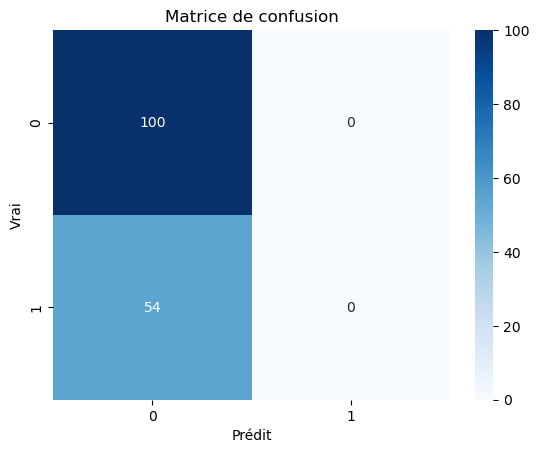

In [23]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.savefig('Matrice de confusion')
plt.show()

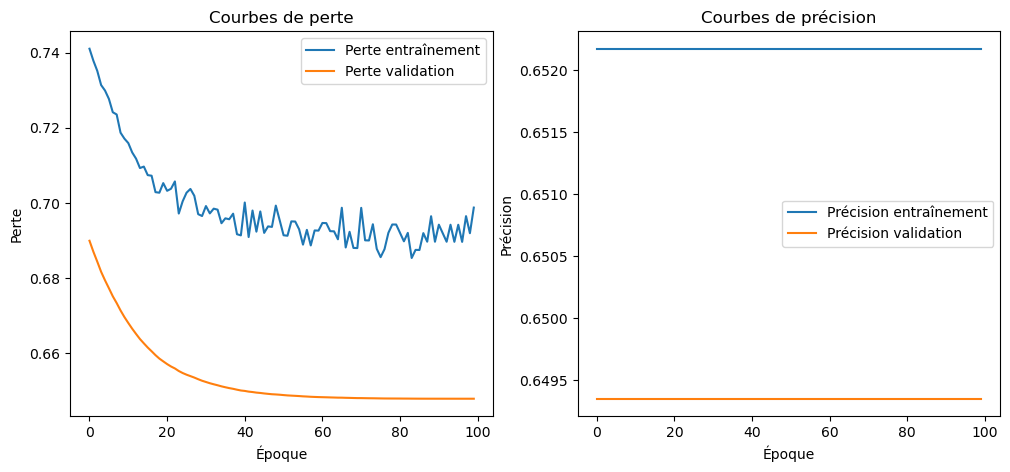

In [25]:
# Courbes de perte et d’accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Courbe de perte
ax1.plot(train_losses, label='Perte entraînement')
ax1.plot(val_losses, label='Perte validation')
ax1.set_title('Courbes de perte')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte')
ax1.legend()
# Courbe de précision
ax2.plot(train_accuracies, label='Précision entraînement')
ax2.plot(val_accuracies, label='Précision validation')
ax2.set_title('Courbes de précision')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Précision')
ax2.legend()
plt.savefig('Courbes de précision et perte')
plt.show()
